In [1]:
import sys
sys.path.append("/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/code/modules")
import pickle
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import torch
from dynamical_models   import *
from generate_data      import *
from NbedDyn            import *
from stat_functions     import *

seed = 0
with open('/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/data/SLA_database.pkl', 'rb') as f:
    data = pickle.load(f)
N_eof_HRRes20 = 15
X_train = data['X_train']
mu      = data['mu']
coef    = data['coef']
sea_idx = data['sea_idx']

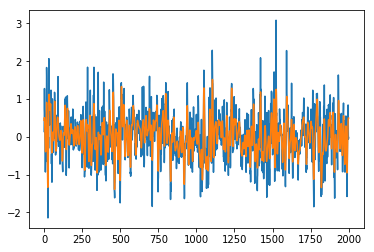

In [2]:
X_train_F = np.zeros((1,2230,N_eof_HRRes20))

for i in range(X_train_F.shape[-1]):
    fc = 0.08
    b = 0.08
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    for j in range(X_train.shape[0 ]):
        s = list(X_train[j,:,i])
        X_train_F[j,:,i] = np.convolve(s, sinc_func)
    
    
plt.plot(X_train[0,:2000,0])
plt.plot(X_train_F[0,25:2000+25,0])

In [3]:
X_train_F_T = X_train_F[0,25:X_train_F.shape[1]-25,:]
mean_of_array = X_train_F_T.mean(axis=0)
std_of_array = X_train_F_T.std(axis=0)
X_train_F_T = preprocessing.scale(X_train_F_T)

In [4]:
X_test = X_train_F_T[X_train_F_T.shape[0]-178:,:]
X_train= X_train_F_T[:X_train_F_T.shape[0]-178,:]
Grad_t   = np.gradient(X_train[:,:])[0].reshape(X_train.shape[0],N_eof_HRRes20)/1.0
Batch_size = X_train.shape[0]
nb_batch   = int(X_train.shape[0]/Batch_size)
X_train    = X_train.reshape(nb_batch,Batch_size,N_eof_HRRes20)
Grad_t     = Grad_t.reshape(nb_batch,Batch_size,N_eof_HRRes20)

In [7]:
pretrained = False
rr = 0
for N_latent in range(15,60,15):
    for seed in range(3):
        params = {}
        params['seed']               = seed
        params['transition_layers']  = N_eof_HRRes20
        params['bi_linear_layers']   = N_latent+N_eof_HRRes20
        params['dim_hidden_linear']  = N_latent+N_eof_HRRes20
        params['dim_input']          = N_eof_HRRes20
        params['dim_latent']         = N_latent
        params['dim_observations']   = N_eof_HRRes20
        params['dim_Embedding']      = N_latent+N_eof_HRRes20
        params['ntrain']             = [30000,1000]
        params['dt_integration']     = 1.0
        params['pretrained']         = True
        params['nb_batch']           = nb_batch
        params['Batch_size']         = Batch_size
        params['get_latent_train']   = True
        params['path']               = '/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/'
        params['file_name']          = 'NbedDyn_SLA_dim_'+str(params['dim_Embedding'])+'_seed_'+str(params['seed'])
        model, modelRINN = get_NbedDyn_model(params)
        if params['pretrained'] :
            model.load_state_dict(torch.load(params['path']+params['file_name']+'.pt'))
        else:
            model, modelRINN, aug_inp_data = train_NbedDyn_model_SLA(params,model,modelRINN,X_train,Grad_t)
        pred = [torch.cat((torch.from_numpy(X_train).float()[-1,-1:,:], modelRINN.Dyn_net.y_aug[-1,-1:,:]), dim=1)]

        for i in range(10000):
            pred.append(modelRINN(pred[-1],params['dt_integration'])[0])
        if rr==0:
            X_test = (X_test * std_of_array) + mean_of_array
        pred_raw= (torch.stack(pred).data.numpy()[:,0,:N_eof_HRRes20] * std_of_array) + mean_of_array
        forecasting_err=np.zeros(1000)
        for i in range(1,100):
            forecasting_err[i-1]=RMSE(X_test[i-1,:],pred_raw[i,:N_eof_HRRes20])

        print('prediction error at t0 + dt : '  ,forecasting_err[0])
        print('prediction error at t0 + 4dt : ' ,forecasting_err[3])

        output_results = {}
        output_results['description']    = 'nbedDyn_model_output_dim'+str(params['dim_observations'])+'_seed_'+str(seed)
        output_results['pred']           = pred_raw
        output_results['forecast_error'] = forecasting_err
        # write python dict to a file
        output = open(params['path']+params['file_name']+'.pkl', 'wb')
        pickle.dump(output_results, output)
        output.close()
        torch.save(model.state_dict(), params['path']+params['file_name']+'.pt')
        rr+=1

prediction error at t0 + dt :  0.008081747356351447
prediction error at t0 + 4dt :  0.048785475563095176
prediction error at t0 + dt :  0.008552846851617908
prediction error at t0 + 4dt :  0.05278431377771653
prediction error at t0 + dt :  0.009143607699359665
prediction error at t0 + 4dt :  0.04908683667536722
prediction error at t0 + dt :  0.004842040866062986
prediction error at t0 + 4dt :  0.030414544129178954
prediction error at t0 + dt :  0.006533646411693006
prediction error at t0 + 4dt :  0.029480525860953528
prediction error at t0 + dt :  0.0032217925268536764
prediction error at t0 + 4dt :  0.0369224968798894
prediction error at t0 + dt :  0.006145928623621037
prediction error at t0 + 4dt :  0.053645658696401095
prediction error at t0 + dt :  0.004163594114151299
prediction error at t0 + 4dt :  0.0364156100705971
prediction error at t0 + dt :  0.004540935843382396
prediction error at t0 + 4dt :  0.062530624590588


In [6]:
DataPred = np.dot(pred_raw, coef.T) +mu
DataFil = np.dot(X_test, coef.T) +mu

pred_patch  = np.zeros((X_test.shape[0],35*35))*np.nan
fil_patch   = np.zeros((X_test.shape[0],35*35))*np.nan
pred_patch[:,sea_idx]  = DataPred[:X_test.shape[0],:]
fil_patch[:,sea_idx]   = DataFil

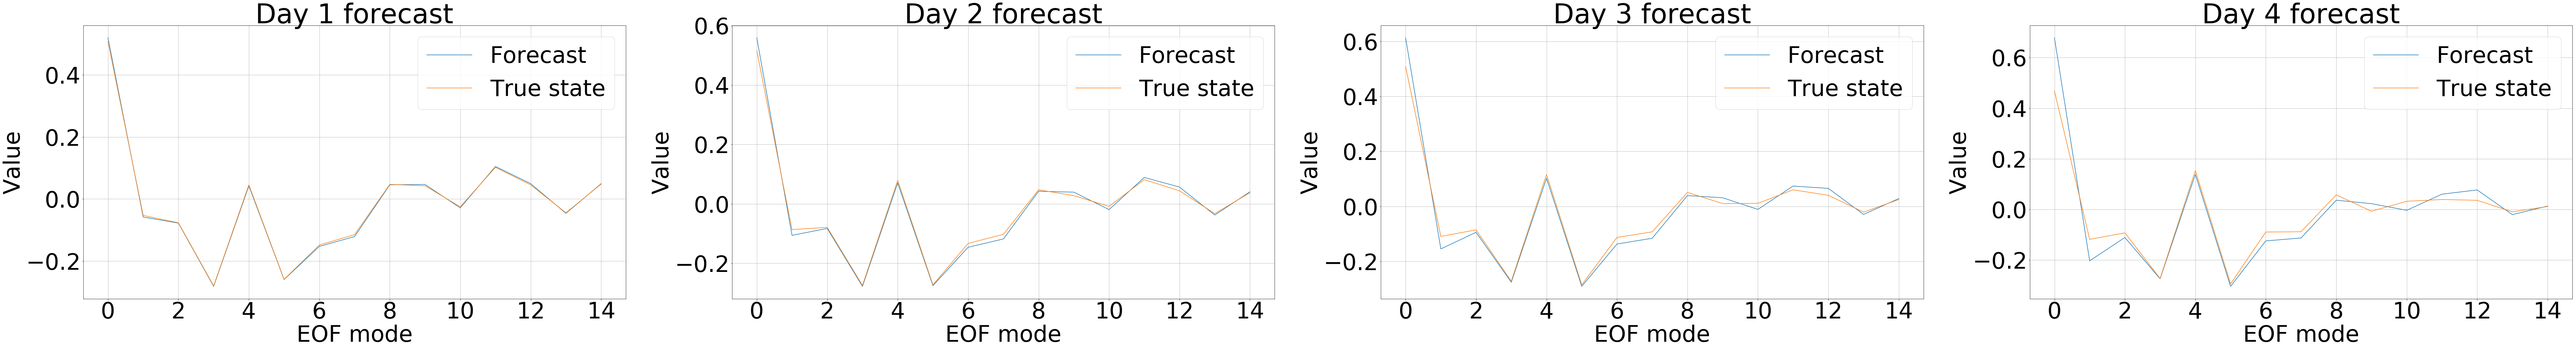

In [12]:
plt.rcParams.update({'font.size': 62})
fig = plt.figure(figsize=(100, 15)) 
plt.subplot(141)
plt.plot(pred_raw[1,:15], label="Forecast")
plt.plot(X_test[0,:], label="True state")
plt.xlabel('EOF mode')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.title("Day 1 forecast")

plt.subplot(142)
plt.plot(pred_raw[2,:15], label="Forecast")
plt.plot(X_test[1,:], label="True state")
plt.xlabel('EOF mode')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.title("Day 2 forecast")

plt.subplot(143)
plt.plot(pred_raw[3,:15], label="Forecast")
plt.plot(X_test[2,:], label="True state")
plt.xlabel('EOF mode')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.title("Day 3 forecast")

plt.subplot(144)
plt.plot(pred_raw[4,:15], label="Forecast")
plt.plot(X_test[3,:], label="True state")
plt.xlabel('EOF mode')
plt.ylabel('Value')
plt.grid()
plt.legend()
plt.title("Day 4 forecast")
plt.tight_layout()
plt.savefig('Latent_ODE_forecast_eof.pdf')

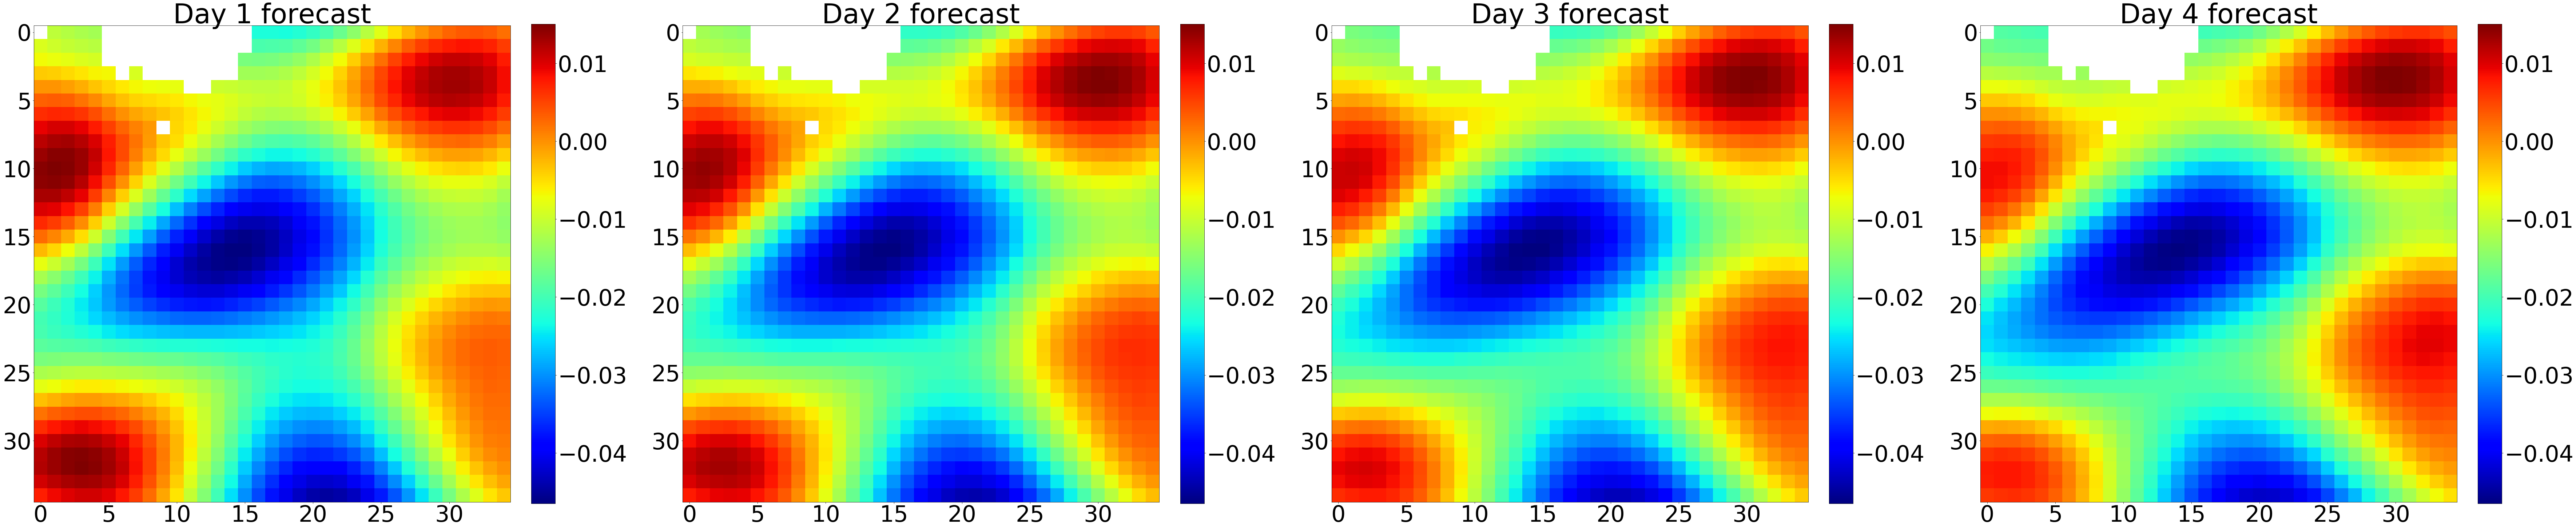

In [8]:
plt.rcParams.update({'font.size': 62})
fig = plt.figure(figsize=(100, 100)) 
plt.subplot(141)
im = plt.imshow(np.reshape(pred_patch[0,:],(35,35)),cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Day 1 forecast")

plt.subplot(142)
plt.imshow(np.reshape(pred_patch[1,:],(35,35)),cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Day 2 forecast")

plt.subplot(143)
plt.imshow(np.reshape(pred_patch[2,:],(35,35)),cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Day 3 forecast")

plt.subplot(144)
plt.imshow(np.reshape(pred_patch[3,:],(35,35)),cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Day 4 forecast")
plt.tight_layout()

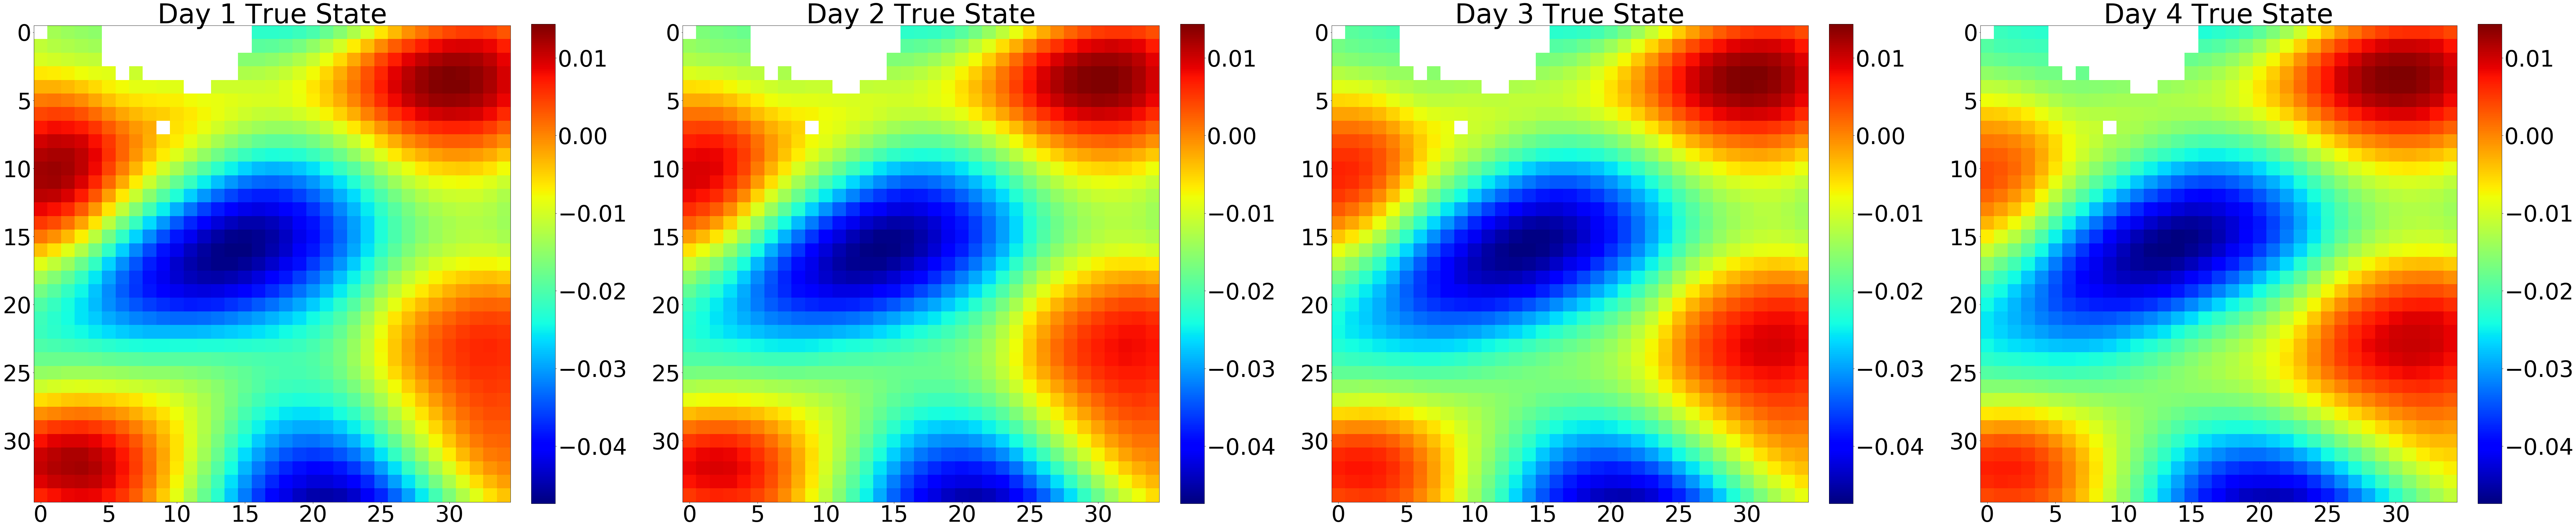

In [9]:
plt.rcParams.update({'font.size': 62})
fig = plt.figure(figsize=(100, 100)) 
plt.subplot(141)
im = plt.imshow(np.reshape(fil_patch[0,:],(35,35)),cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Day 1 True State")

plt.subplot(142)
plt.imshow(np.reshape(fil_patch[1,:],(35,35)),cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Day 2 True State")

plt.subplot(143)
plt.imshow(np.reshape(fil_patch[2,:],(35,35)),cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Day 3 True State")

plt.subplot(144)
plt.imshow(np.reshape(fil_patch[3,:],(35,35)),cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Day 4 True State")
plt.tight_layout()

Text(0, 0.5, 'EOF 1')

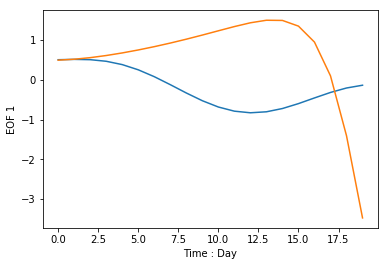

In [15]:
plt.rcParams.update({'font.size': 10})
plt.plot(X_test[:20,0],label = 'True EOF time series')
plt.plot(pred_raw[:20,0],label = 'predicted EOF time series')
plt.xlabel("Time : Day")
plt.ylabel("EOF 1")

In [16]:
axis_font = 65
title_font = 95
import glob
names = []
pred_seq_dim, forecast_error_dim = [], []
for j in range(15,60,15):
    print(j)
    file_name   = sorted(glob.glob(params['path']+'NbedDyn_SLA_dim_'+str(j+N_eof_HRRes20)+'*.pkl'))
    names.append(file_name)
    pred_seq, forecast_error = [], []
    pred_seq_mean, forecast_error_mean = [], []
    pred_seq_stds, forecast_error_stds = [], []
    for i in range(len(file_name)):
        print(file_name[i])
        pkl_file = open(file_name[i],'rb')
        res_dict = pickle.load(pkl_file)
        pkl_file.close()
        pred_seq.append(res_dict['pred'])
        forecast_error.append(res_dict['forecast_error'][0])
    pred_seq_dim.append(np.array(pred_seq))
    forecast_error_dim.append(np.array(forecast_error))

15
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_SLA_dim_30_seed_0.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_SLA_dim_30_seed_1.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_SLA_dim_30_seed_2.pkl
30
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_SLA_dim_45_seed_0.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_SLA_dim_45_seed_1.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_SLA_dim_45_seed_2.pkl
45
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_SLA_dim_60_seed_0.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_SLA_dim_60_seed_1.pkl
/home/AI4OAC-VM1/notebooks/AI4OAC/CHAOS_paper/output/NbedDyn_SLA_dim_60_seed_2.pkl


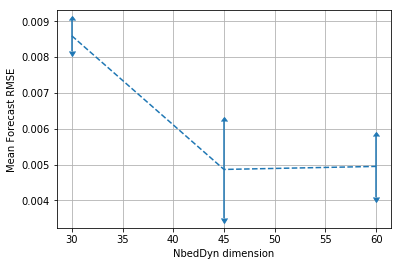

In [12]:
mean_per_dim_test  = np.zeros(len(forecast_error_dim))
std_per_dim_test   = np.zeros(len(forecast_error_dim))

for i in range(mean_per_dim_test.shape[0]):
    
    mean_per_dim_test[i] = np.nanmean(forecast_error_dim[i])
    std_per_dim_test[i] = np.nanstd(forecast_error_dim[i])
    
x = np.arange(15,60,15)
plt.errorbar(x+N_eof_HRRes20, mean_per_dim_test,std_per_dim_test,linestyle='--', uplims=True, lolims=True)
plt.xlabel('NbedDyn dimension')
plt.ylabel('Mean Forecast RMSE')
plt.grid()
plt.show()